## Prediction of extreme snowmelt from SHMI data

In [1]:
import pandas as pd
import seaborn as sns

### Data cleaning and exploration

In [2]:
# import files

snow_df = pd.read_csv('../snow.csv', low_memory=False)
flow_df = pd.read_csv('../flow.csv', low_memory=False)
snow_sites = pd.read_csv('../snow_sites.csv', low_memory=False)
flow_sites = pd.read_csv('../flow_sites.csv', low_memory=False)
site_pairs = pd.read_csv('../site_pairs_clean.csv', low_memory=False)


In [3]:
# Some data exploration
snow_df = snow_df[snow_df['snow_depth'].notna()]
snow_df = snow_df[snow_df['snow_depth'] != 'Snödjup']
snow_df.isnull().sum()
snow_df['snow_depth'] = snow_df['snow_depth'].astype(float)
snow_df.date = pd.to_datetime(snow_df.date)
snow_df['year'] = snow_df.date.dt.year
snow_df.head()


,date,time,snow_depth,quality,site_id,id,name,latitude,longitude,year
0,1945-01-02,07:00:00,0.67,G,173010,173010,Aapua,66.8656,23.4951,1945
1,1945-01-03,07:00:00,0.67,G,173010,173010,Aapua,66.8656,23.4951,1945
2,1945-01-04,07:00:00,0.66,G,173010,173010,Aapua,66.8656,23.4951,1945
3,1945-01-05,07:00:00,0.65,G,173010,173010,Aapua,66.8656,23.4951,1945
4,1945-01-06,07:00:00,0.65,G,173010,173010,Aapua,66.8656,23.4951,1945


In [4]:
snow_df.shape

(6365690, 10)

In [5]:
flow_df = flow_df.drop(['Unnamed: 0'], axis=1)
flow_df.columns = ['date', 'flow', 'quality', 'site_id', 'id', 'name', 'latitude', 'longitude']
flow_df = flow_df[flow_df['flow'].notna()]
flow_df.date = pd.to_datetime(flow_df.date)
flow_df.head()


,date,flow,quality,site_id,id,name,latitude,longitude
0,1984-08-17,106.7242,G,2357,2357,ABISKO,68.3559,18.8208
1,1984-08-18,103.7052,G,2357,2357,ABISKO,68.3559,18.8208
2,1984-08-19,99.4413,G,2357,2357,ABISKO,68.3559,18.8208
3,1984-08-20,93.1354,G,2357,2357,ABISKO,68.3559,18.8208
4,1984-08-21,93.7860,G,2357,2357,ABISKO,68.3559,18.8208


In [6]:
flow_df.shape

(7377920, 8)

In [7]:
# convert snow depth to binary variable (1 if depth is more than 0.05m shallower than two days before)
snow_df1 = snow_df[snow_df['site_id'] == 173010]
snow_df1 = snow_df.sort_values(by=['site_id', 'date'])
snow_df['depth_diff'] = snow_df.groupby(['site_id']).snow_depth.diff(periods=2)
snow_df['binary'] = (snow_df['depth_diff'] < -0.05).astype(int)
snow_df.head()


,date,time,snow_depth,quality,site_id,id,name,latitude,longitude,year,depth_diff,binary
0,1945-01-02,07:00:00,0.67,G,173010,173010,Aapua,66.8656,23.4951,1945,NaN,0
1,1945-01-03,07:00:00,0.67,G,173010,173010,Aapua,66.8656,23.4951,1945,NaN,0
2,1945-01-04,07:00:00,0.66,G,173010,173010,Aapua,66.8656,23.4951,1945,-0.01,0
3,1945-01-05,07:00:00,0.65,G,173010,173010,Aapua,66.8656,23.4951,1945,-0.02,0
4,1945-01-06,07:00:00,0.65,G,173010,173010,Aapua,66.8656,23.4951,1945,-0.01,0


In [8]:
# remove rows where previous value is not two days away
snow_df['date_diff'] = snow_df.groupby(['site_id']).date.diff(periods=2)
snow_df = snow_df[snow_df['date_diff'] == pd.Timedelta(days=2)]

In [9]:
# some cleaning - remove null values and duplicate rows
snow_df = snow_df[snow_df['binary'].notna()]
snow_df.binary.value_counts()

0    5476226
1     298996
Name: binary, dtype: int64

In [10]:
print('Percentage of extreme snowmelt events: ', round(snow_df.binary.sum() / snow_df.binary.count() * 100, 2), '%')

Percentage of extreme snowmelt events:  5.18 %


In [11]:
snow_df[snow_df['binary'] == 1]

,date,time,snow_depth,quality,site_id,id,name,latitude,longitude,year,depth_diff,binary,date_diff
81,1945-03-24,07:00:00,0.78,G,173010,173010,Aapua,66.8656,23.4951,1945,-0.06,1,2 days
85,1945-03-28,07:00:00,0.68,G,173010,173010,Aapua,66.8656,23.4951,1945,-0.06,1,2 days
86,1945-03-29,07:00:00,0.66,G,173010,173010,Aapua,66.8656,23.4951,1945,-0.06,1,2 days
107,1945-04-19,07:00:00,0.50,G,173010,173010,Aapua,66.8656,23.4951,1945,-0.05,1,2 days
115,1945-04-27,07:00:00,0.31,G,173010,173010,Aapua,66.8656,23.4951,1945,-0.09,1,2 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6366665,2011-04-12,06:00:00,0.40,G,171700,171700,Övre Svartlå D,66.0213,21.1727,2011,-0.08,1,2 days
6366667,2011-04-14,06:00:00,0.35,G,171700,171700,Övre Svartlå D,66.0213,21.1727,2011,-0.05,1,2 days
6366668,2011-04-15,06:00:00,0.30,G,171700,171700,Övre Svartlå D,66.0213,21.1727,2011,-0.10,1,2 days
6366670,2011-04-17,06:00:00,0.00,G,171700,171700,Övre Svartlå D,66.0213,21.1727,2011,-0.30,1,2 days


In [12]:
site_pairs.columns = ['Bas0_ID', 'BASINNAME', 'Mean_Elev', 'Shape_Leng', 'Shape_Area',
                      'flow_site_id', 'snow_site_id', 'snow_name', 'snow_latitude',
                      'snow_longitude', 'snow_year_count', 'snow_obs_per_ye', 'distance']
site_pairs.head()


,Bas0_ID,BASINNAME,Mean_Elev,Shape_Leng,Shape_Area,flow_site_id,snow_site_id,snow_name,snow_latitude,snow_longitude,snow_year_count,snow_obs_per_ye,distance
0,W3B2002700,NaN,440.424335,55600,64270000,4,181970,Esrange,67.8907,21.0832,33,228.333333,79502.045451
1,W3B2002700,NaN,440.424335,55600,64270000,4,180940,Kiruna flygplats,67.8270,20.3387,36,141.638889,102500.768170
2,W3B2002700,NaN,440.424335,55600,64270000,4,180960,Kiruna,67.8514,20.2496,111,111.351351,107047.616796
3,W3B2002700,NaN,440.424335,55600,64270000,4,189760,Torneträsk,68.2201,19.7123,15,239.733333,147286.250971
4,W3B2002700,NaN,440.424335,55600,64270000,4,188800,Abisko,68.3538,18.8166,69,132.637681,186365.745096


In [36]:
# merge snow and flow data
all_data = pd.merge(snow_df[['date', 'site_id', 'snow_depth', 'depth_diff', 'binary']], site_pairs[['flow_site_id', 'snow_site_id', 'distance']], left_on='site_id', 
	right_on='snow_site_id', how='left')
all_data = all_data[all_data['distance'].notna()]
all_data.drop(['site_id'], axis=1, inplace=True)
all_data = pd.merge(all_data, flow_df[['date', 'site_id', 'flow']], left_on=['date', 'flow_site_id'], right_on=['date', 'site_id'], how='inner')
all_data.drop(['site_id'], axis=1, inplace=True)
all_data.head()


,date,snow_depth,depth_diff,binary,flow_site_id,snow_site_id,distance,flow
0,1945-05-23,0.0,0.0,0,51.0,157010.0,35296.19718,182.0
1,1945-05-24,0.0,0.0,0,51.0,157010.0,35296.19718,176.0
2,1945-05-25,0.0,0.0,0,51.0,157010.0,35296.19718,164.0
3,1945-05-26,0.0,0.0,0,51.0,157010.0,35296.19718,152.0
4,1945-05-27,0.0,0.0,0,51.0,157010.0,35296.19718,143.0


In [37]:
all_data.shape

(1556673, 8)

In [38]:
all_data.binary.value_counts()

0    1468371
1      88302
Name: binary, dtype: int64

In [39]:
print('Percentage of extreme snowmelt events: ', round(
    all_data.binary.sum() / all_data.binary.count() * 100, 2), '%')


Percentage of extreme snowmelt events:  5.67 %


In [40]:
# check which sites have more than 10 years of overlapping data
freq_df = all_data.groupby(['flow_site_id', 'snow_site_id'])['date'].agg([('year_count', lambda x: x.dt.year.max() - x.dt.year.min()),
                                                  ('obs_per_year', lambda x: x.count() / (x.dt.year.max() - x.dt.year.min()))])
freq_df = freq_df.reset_index()
freq_df = freq_df[(freq_df['year_count'] >= 10) & (freq_df['obs_per_year'] >= 100)]
freq_df

<ipython-input-40-514b76abe780>:3: RuntimeWarning: divide by zero encountered in long_scalars
  ('obs_per_year', lambda x: x.count() / (x.dt.year.max() - x.dt.year.min()))])


,flow_site_id,snow_site_id,year_count,obs_per_year
0,4.0,180940.0,26,287.153846
2,4.0,181970.0,33,248.333333
3,4.0,188800.0,54,201.759259
4,4.0,188820.0,51,330.960784
6,4.0,189760.0,24,243.958333
...,...,...,...,...
308,2506.0,148200.0,15,344.866667
309,10006.0,191900.0,24,302.208333
310,10006.0,191940.0,14,371.714286
311,10006.0,192830.0,49,287.346939


In [41]:
# only keep sites with more than 10 years of overlapping data
all_data_clean = all_data[(all_data['flow_site_id'].isin(freq_df['flow_site_id'])) & (all_data['snow_site_id'].isin(freq_df['snow_site_id']))]
all_data_clean.binary.value_counts()

0    1420814
1      85438
Name: binary, dtype: int64

In [42]:
print('Percentage of extreme snowmelt events: ', round(
    all_data_clean.binary.sum() / all_data_clean.binary.count() * 100, 2), '%')


Percentage of extreme snowmelt events:  5.67 %


In [43]:
all_data_clean.head()

,date,snow_depth,depth_diff,binary,flow_site_id,snow_site_id,distance,flow
0,1945-05-23,0.0,0.0,0,51.0,157010.0,35296.19718,182.0
1,1945-05-24,0.0,0.0,0,51.0,157010.0,35296.19718,176.0
2,1945-05-25,0.0,0.0,0,51.0,157010.0,35296.19718,164.0
3,1945-05-26,0.0,0.0,0,51.0,157010.0,35296.19718,152.0
4,1945-05-27,0.0,0.0,0,51.0,157010.0,35296.19718,143.0


In [44]:
all_data_clean.isnull().sum()

date            0
snow_depth      0
depth_diff      0
binary          0
flow_site_id    0
snow_site_id    0
distance        0
flow            0
dtype: int64

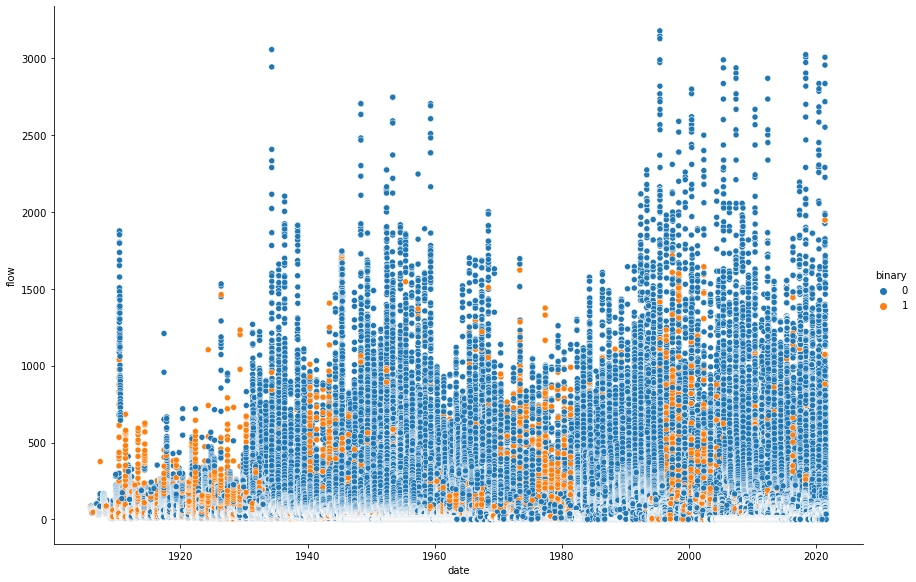

In [45]:
sns.relplot(x="date", y="flow", data=all_data_clean,
            hue="binary", kind="scatter", height=8, aspect=1.5)


<ipython-input-46-4cf8c10f4902>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_clean['year'] = all_data_clean.date.dt.year


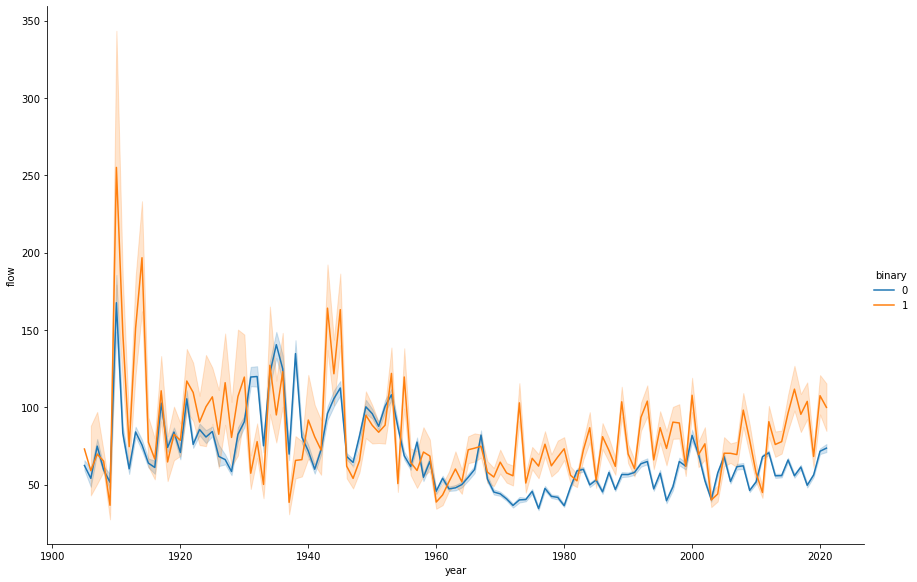

In [46]:
all_data_clean['year'] = all_data_clean.date.dt.year
sns.relplot(x="year", y="flow", hue="binary", data=all_data_clean, kind="line", height=8, aspect=1.5)


<ipython-input-47-ccc1aef8568a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_clean['month'] = all_data_clean.date.dt.month


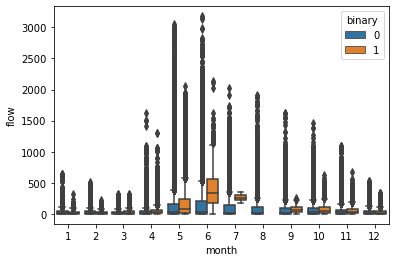

In [47]:
all_data_clean['month'] = all_data_clean.date.dt.month
sns.boxplot(x="month", y="flow", hue="binary", data=all_data_clean)


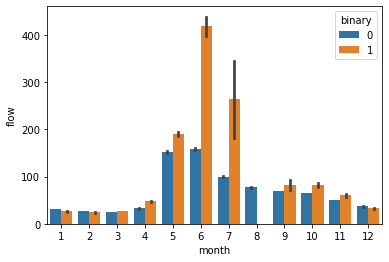

In [48]:
sns.barplot(x="month", y="flow", hue="binary", data=all_data_clean)

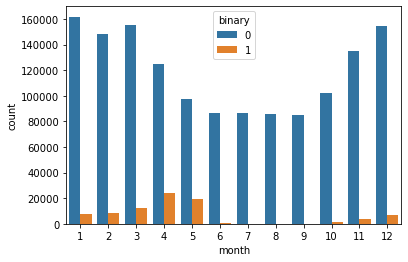

In [49]:
sns.countplot(x="month", hue="binary", data=all_data_clean)


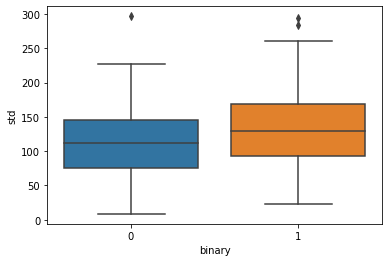

In [50]:

year_mean = all_data_clean.groupby(['year', 'binary'])['flow'].agg(['mean', 'std']).reset_index()
sns.boxplot(x="binary", y="std", data=year_mean)

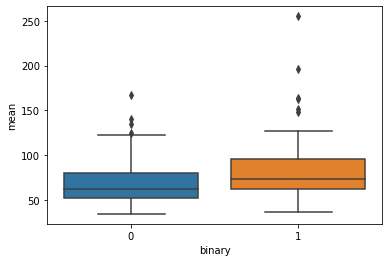

In [51]:
sns.boxplot(x="binary", y="mean", data=year_mean)


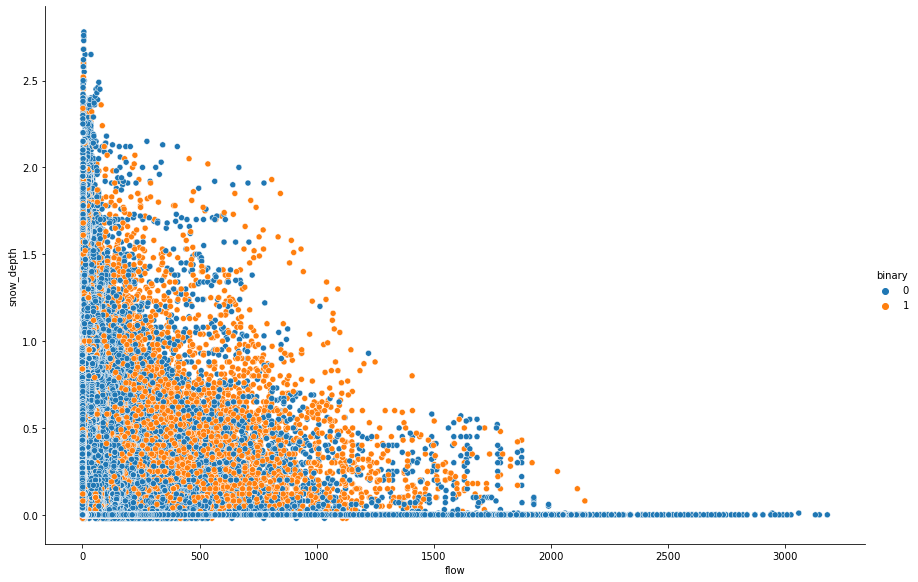

In [58]:
sns.relplot(x="flow", y="snow_depth", hue="binary", data=all_data_clean, kind="scatter", height=8, aspect=1.5)

In [52]:
# TODO: some plots and stats: how unbalanced is the snow depth data?

### Building the model

#### Snow depth and flow only

In [53]:
# Models to try:
# 1. Recursive Neural Network
# 2. Convolutional Neural Network
# 3. Support Vector Machine
# Various time lags?


In [54]:
# Validation:
# 1. Forecast latest 2 or 5 years for every site
# 2. Keep 5 or 10 sites to check for extrapolation
# Metric: AUC-PR

In [55]:
# Initially only snow depth vs flow, but potentially consider:
# 1. distance between sites (threshold or covariate)
# 2. temperature (nearest to flow site)
# 3. precipitation (nearest to flow site)
# 4. year (any temporal trend?)